In [1]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Initialize the environment

In [4]:
env = gym.make("LunarLander-v3") # render_mode = 'human'
state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 8
Action Space: 4


### Policy

In [5]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.99
epsilon = 0.1
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 1000

In [7]:
policy_net = DQN(state_space, action_space)
target_net = DQN(state_space, action_space)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()

In [8]:
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [9]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    rand_value = random.random()
    if rand_value < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    # the maximum step of one episode
    count = 0

    # One episode (One Trajectory)
    while not done:
        if isinstance(state, tuple):
            state = state[0]

        if count > 9999:
          break

        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ , _ = env.step(action)

        # Store transition in memory
        memory.append((state, action, reward, next_state, done))


        # Update state
        state = next_state
        episode_reward += reward

        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

        count += 1

    # Decay epsilon
    print('Episode ',episode,': Reward = ',episode_reward)

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    rewards_per_episode.append(episode_reward)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24056\1411022965.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state_batch = torch.FloatTensor(state_batch)


Episode  0 : Reward =  -502.21809905878695
Episode  1 : Reward =  -355.00892749006056
Episode  2 : Reward =  -240.94866225900444
Episode  3 : Reward =  -130.63671436519036
Episode  4 : Reward =  -123.91263934487668
Episode  5 : Reward =  -291.1806931438978
Episode  6 : Reward =  -143.8036172967441
Episode  7 : Reward =  -131.99810358857746
Episode  8 : Reward =  -130.75520516170297
Episode  9 : Reward =  -146.69855754676013
Episode  10 : Reward =  -101.6645593483324
Episode  11 : Reward =  -106.93237314482896
Episode  12 : Reward =  -97.41638474778156
Episode  13 : Reward =  -161.59081811596732
Episode  14 : Reward =  -133.82711300103506
Episode  15 : Reward =  -156.91413643905065
Episode  16 : Reward =  -118.63167892784031
Episode  17 : Reward =  -158.73354936993636
Episode  18 : Reward =  -124.38582280616731
Episode  19 : Reward =  -210.62670179683053
Episode  20 : Reward =  -337.26759049749944
Episode  21 : Reward =  -337.28013775439365
Episode  22 : Reward =  -285.8529818016872
Epi

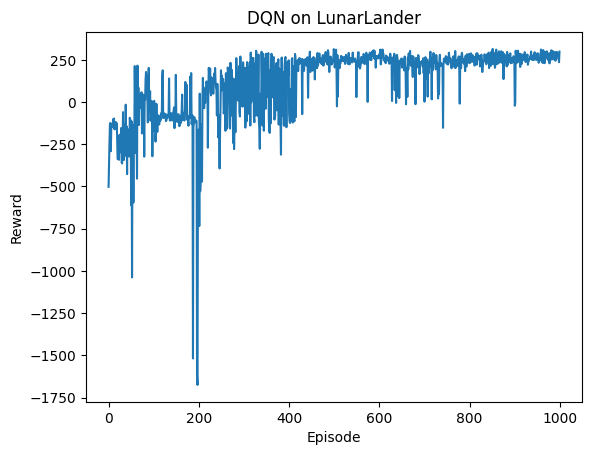

In [10]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on LunarLander')
plt.show()